In [27]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sbn
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler,SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import sklearn.metrics as metrics
%matplotlib inline
sbn.set_style("darkgrid")
colors1 = sbn.color_palette(['#FF7D40'], 1)

# Data Reading

In [28]:
DF = pd.read_csv('heart_2020_cleaned.csv').reset_index().rename(columns={'index':'id'})

In [29]:
CatCols = [
    'Smoking','AlcoholDrinking','Stroke','DiffWalking','Sex','AgeCategory','Race','Diabetic',
    'PhysicalActivity','GenHealth','Asthma','KidneyDisease','SkinCancer'
]
NumCols = [
    'BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime'
]

X = DF[DF.columns.difference(['id','HeartDisease'])]
Y = DF['HeartDisease']
X.shape

(319795, 17)

# Data Cleaning

In [41]:
#check the Missing Values
DF.isnull().sum()

id                  0
HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

C:\Users\allam\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  if __name__ == "__main__":


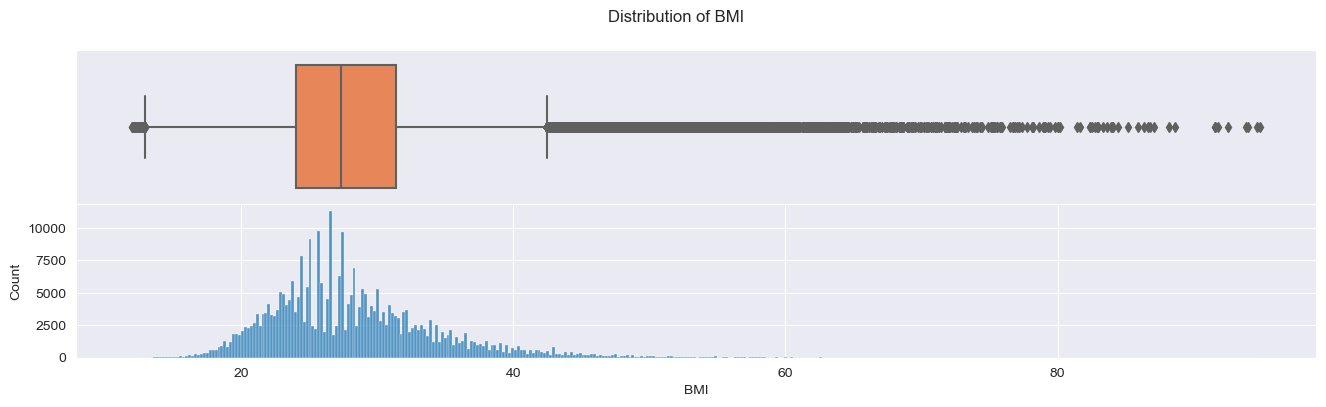

C:\Users\allam\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  if __name__ == "__main__":


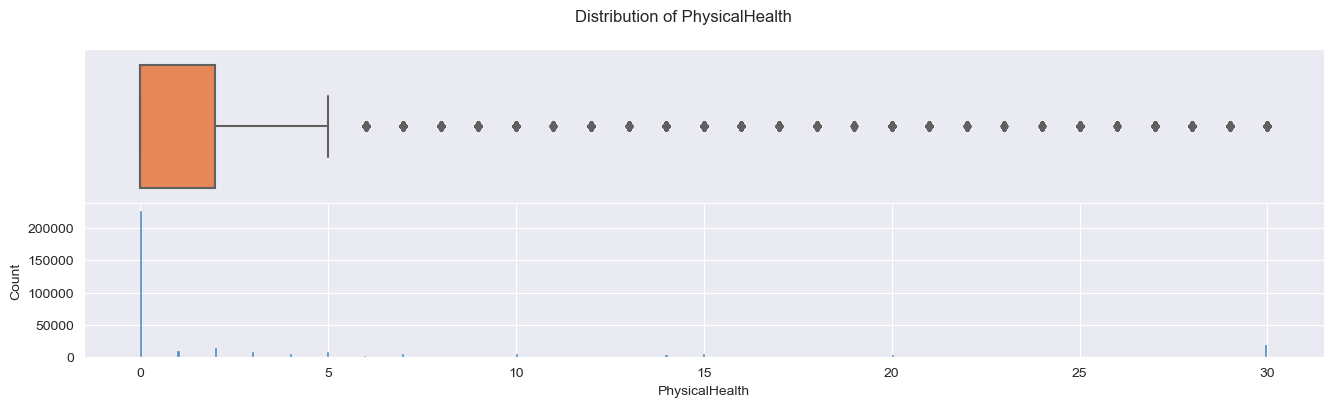

C:\Users\allam\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  if __name__ == "__main__":


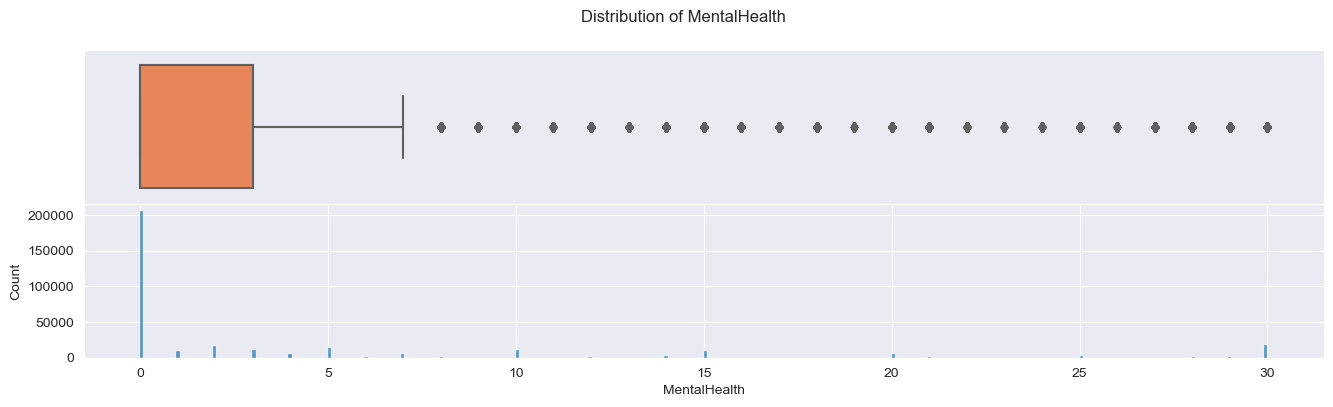

C:\Users\allam\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  if __name__ == "__main__":


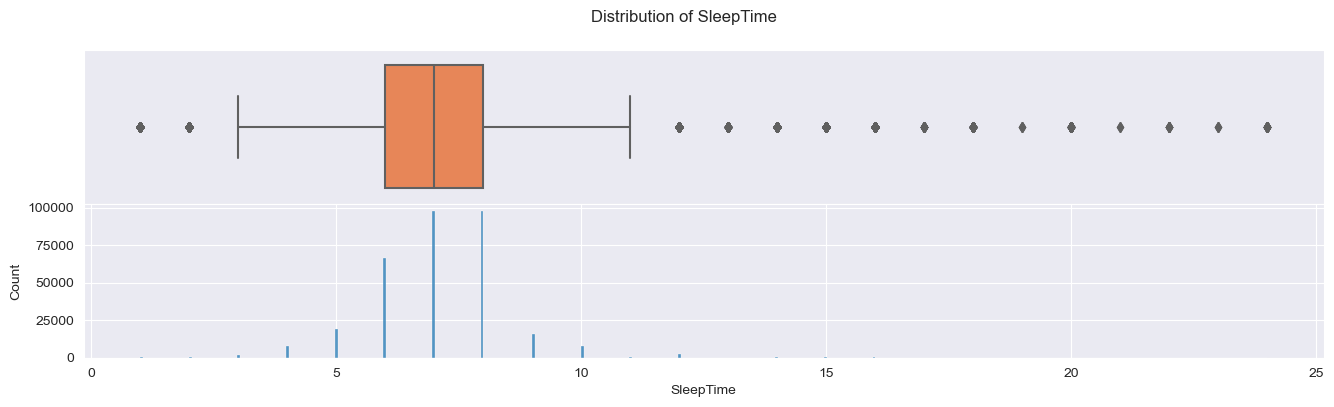

In [30]:
#Outliers Detection with Boxplot
n = len(NumCols)
for col in NumCols:
  fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16, 4))
  plt.suptitle(f"Distribution of {col}")
  sbn.boxplot(data=DF, x=col, ax=ax1, palette=colors1)
  ax1.set_xlabel(None)
  ax1.get_xaxis().set_ticks([])
  sbn.histplot(data=DF, x=col, ax=ax2, palette=colors1)
  plt.subplots_adjust(hspace=0)
  print("\n")
  plt.show()

In [31]:
#Outliers Detection with IQR
for col in NumCols:
  Q1, Q3 = DF[col].quantile([0.25,0.75])
  IQR = Q3 - Q1
  right = Q3 + 1.5 * IQR
  left = Q1 - 1.5 * IQR
  n = len(DF.loc[(DF[col] < left) | (DF[col] > right)])
  print(f"{col}:\n\tOutlier Num = {n}\n\tOutlier Percentage = {n*100/len(DF):.2f}%\n")

BMI:
	Outlier Num = 10396
	Outlier Percentage = 3.25%

PhysicalHealth:
	Outlier Num = 47146
	Outlier Percentage = 14.74%

MentalHealth:
	Outlier Num = 51576
	Outlier Percentage = 16.13%

SleepTime:
	Outlier Num = 4543
	Outlier Percentage = 1.42%



In [32]:
#Outliers Removal with Zscore
zs = X.copy()
for col in NumCols:
  zs[col] = zscore(zs[col])
outscores = np.abs(zs[NumCols])
no_outliers = (outscores<=3.3).all(axis=1)
DF2 = X[no_outliers]
DF2.shape

(294402, 17)

# Data Transformation:

In [33]:
def columns_OHC_transform (DF2,columns):
    merged = pd.DataFrame()
    for column_name in columns:
        label_encoder = LabelEncoder()
        encoded = label_encoder.fit_transform(DF2[column_name])
        labels =pd.Series(label_encoder.classes_)

        clmt = ColumnTransformer([(column_name,OneHotEncoder(),[0])], remainder='passthrough')
        clmt_fited_data = clmt.fit_transform(DF2[[column_name]]) 
        clmt_fited_data = clmt_fited_data if type(clmt_fited_data)== np.ndarray else clmt_fited_data.toarray()
        NDF = pd.DataFrame(clmt_fited_data,columns=[f'{column_name}_{x}' for x in labels]).set_index(DF2.index)
        merged = pd.concat([merged,NDF],axis=1)
    DF2 = DF2.drop(columns=columns)
    DF2 = DF2.merge(merged, left_index=True,right_index=True)

    return DF2

In [34]:
X_OHC = columns_OHC_transform (DF2,CatCols) 
Y_label_encoder = LabelEncoder()
Y = DF.iloc[X_OHC.index]['HeartDisease']
Y_OHC = Y_label_encoder.fit_transform(Y)
X_OHC.shape

(294402, 50)

# Feature Scaling (Numerical Features)

In [35]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
X_OHC_Norm = X_OHC.copy()
ss = StandardScaler()
X_OHC_Norm[NumCols] = ss.fit_transform(X_OHC[NumCols])

# Splitting Data

In [36]:
x_train,x_test,y_train,y_test=train_test_split(X_OHC_Norm,Y_OHC,test_size=0.25,random_state=42)
x_train.shape

(220801, 50)

# Solving Imbalance Class: 

In [37]:
smote = SMOTE()
X_imb, Y_imb = smote.fit_resample(x_train,y_train)
x_t = pd.DataFrame(X_imb)
y_t= pd.DataFrame(Y_imb)
DF_imb = pd.concat([x_t, y_t],axis=1)
DF_imb.shape

(408606, 51)

# Modeling

# Evaluation

# K-Fold Cross-Validation

In [38]:
gnb = GaussianNB()
gnb.fit(x_t, y_t)

C:\Users\allam\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [39]:
y_predict=gnb.predict(x_test)
print(metrics.classification_report(y_test,y_predict))
print(metrics.confusion_matrix(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.98      0.63      0.77     68052
           1       0.15      0.83      0.26      5549

    accuracy                           0.64     73601
   macro avg       0.57      0.73      0.51     73601
weighted avg       0.92      0.64      0.73     73601

[[42796 25256]
 [  955  4594]]
